<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


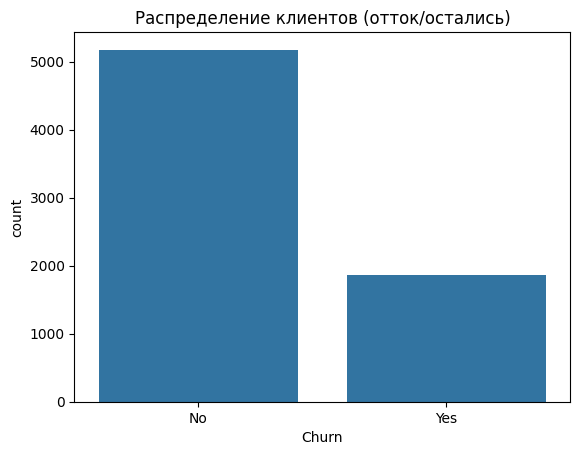

/tmp/ipython-input-3186800289.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


=== LogReg ===
              precision    recall  f1-score   support

       False       0.91      0.72      0.80      1035
        True       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8403239556692241


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:35:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

       False       0.85      0.83      0.84      1035
        True       0.56      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409

ROC-AUC: 0.8161461158903613
=== CatBoost ===
              precision    recall  f1-score   support

       False       0.86      0.84      0.85      1035
        True       0.59      0.61      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC: 0.8365896819861013
LogReg: ROC-AUC = 0.840
XGBoost: ROC-AUC = 0.816
CatBoost: ROC-AUC = 0.837


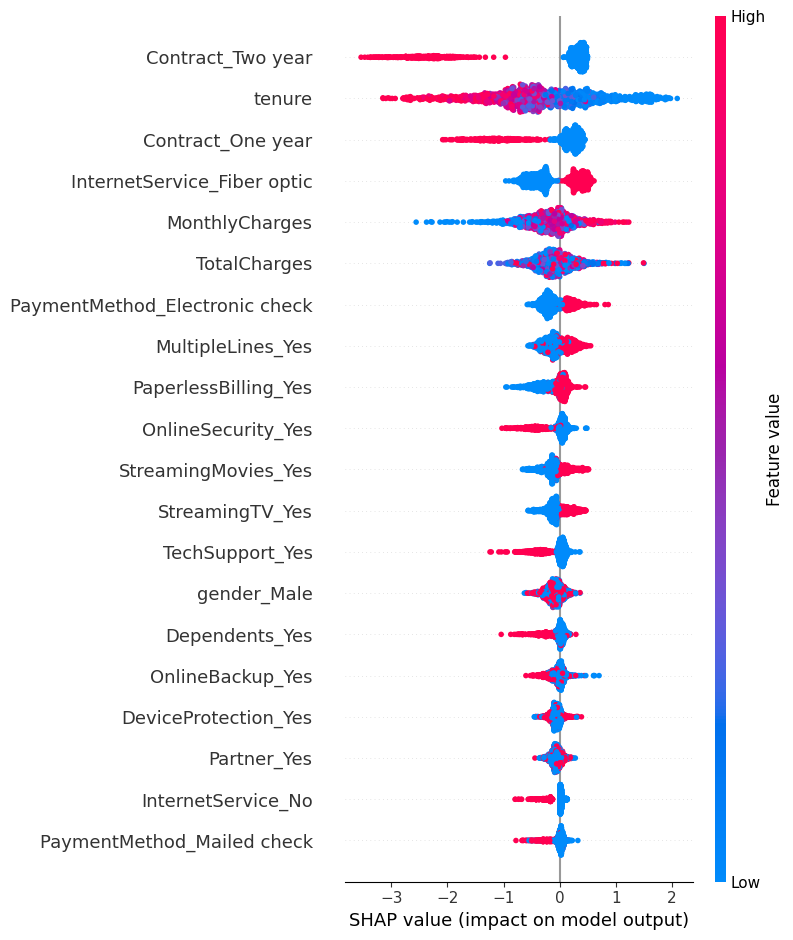

In [ ]:
!pip install catboost imbalanced-learn shap xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
import shap

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)
df.head()

print(df.info())
print(df["Churn"].value_counts(normalize=True))

sns.countplot(x="Churn", data=df)
plt.title("Распределение клиентов (отток/остались)")
plt.show()

df = df.drop(["customerID"], axis=1)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

df = pd.get_dummies(df, drop_first=True)

X = df.drop("Churn_Yes", axis=1)
y = df["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

models = {
    "LogReg": LogisticRegression(max_iter=500, class_weight="balanced"),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    "CatBoost": CatBoostClassifier(verbose=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    results[name] = {
        "report": classification_report(y_test, y_pred, output_dict=True),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

for name, res in results.items():
    print(f"{name}: ROC-AUC = {res['roc_auc']:.3f}")

explainer = shap.TreeExplainer(models["XGBoost"])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=df.drop("Churn_Yes", axis=1).columns)

